# Instalar librerias

In [1]:
!pip install pdfquery
!pip install pdfminer.six

     |████████████████████████████████| 5.6MB 9.5MB/s 
     |████████████████████████████████| 13.7MB 287kB/s 
  Created wheel for pdfquery: filename=pdfquery-0.4.3-cp36-none-any.whl size=16781 sha256=3583852111ac0ef40139c04aa1635fd088d1429ba49cb34c79c30e4cacd486b7
  Stored in directory: /root/.cache/pip/wheels/eb/3b/ac/b14bb31ebd3b27b1c057ea4c38a2f24981280074fd7d64438d
Successfully built pdfquery


# IMPORTS

In [2]:
import pdfquery
from lxml import etree
import re  
from nltk.corpus import stopwords
import io
from pdfminer.converter import TextConverter
from pdfminer.pdfinterp import PDFPageInterpreter
from pdfminer.pdfinterp import PDFResourceManager
from pdfminer.pdfpage import PDFPage
from pdfminer.layout import LAParams

import nltk
nltk.download('stopwords')  
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd 


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# FUNCIONES GENERALES

In [0]:
def extract_text_from_pdf(pdf_path):
    resource_manager = PDFResourceManager()
    fake_file_handle = io.StringIO()
    converter = TextConverter(resource_manager, fake_file_handle)
    page_interpreter = PDFPageInterpreter(resource_manager, converter)
    file = open(pdf_path, 'rb')
    for page in PDFPage.get_pages(file, caching=True,check_extractable=True):
        page_interpreter.process_page(page)
        text = fake_file_handle.getvalue()
    # close open handles
    converter.close()
    fake_file_handle.close()
    if text:
        return text
def extract_pages(pdf_path, pages):
    resource_manager = PDFResourceManager()
    fake_file_handle = io.StringIO()
    converter = TextConverter(resource_manager, fake_file_handle)
    page_interpreter = PDFPageInterpreter(resource_manager, converter)
    file = open(pdf_path, 'rb')
    for page in PDFPage.get_pages(file, caching=True,check_extractable=True, pagenos =pages):
        page_interpreter.process_page(page)
        text = fake_file_handle.getvalue()
    # close open handles
    converter.close()
    fake_file_handle.close()
    if text:
        return text
    

def doClean(text):   
    # Quitar acentos 
    import unidecode
    a = unidecode.unidecode(text)
    # Quitar aquello que no sean palabras o cosa que se le parezca
    a = re.sub(r'\W', ' ', a)
    # Quitar espacios extra en caso de haber
    a = re.sub(r'\s+', ' ', a, flags=re.I)
    # Pasar el texto a minúsulas
    a = a.lower()
    # retirar stopwords
    a = a.split()
    a = [ word for word in a if word not in stopwords.words('spanish')]
    a = " ".join(a)
    # quitar saltos de linea
    #a = re.sub(r'\n', ' ', a)


    return a    


# PP 2019

In [0]:
PDF_PATH_PP_2019 = '2019 Segunda/pp/programa_electoral_pp.pdf'

In [0]:
programa_pp =extract_text_from_pdf(PDF_PATH_PP_2019)

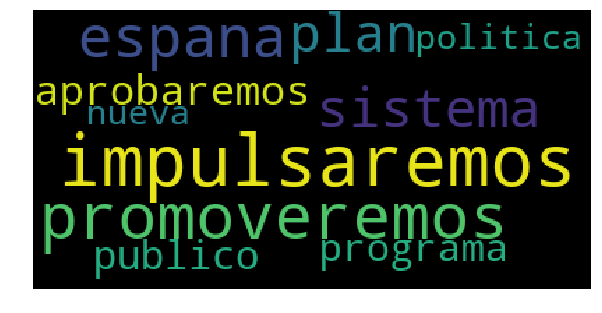

In [0]:
# limpiar
programa_pp_limpio = doClean(programa_pp)
docs = [programa_pp_limpio]
df_pp = pd.DataFrame(docs, columns = ['Programa']) 
from sklearn.feature_extraction.text import TfidfVectorizer
# Elegir cuántas palabras vamos a querer que tenga nuestro vocabulario
tfidfconverter = TfidfVectorizer(max_features=100, use_idf = True)
tfidfconverter.fit(df_pp)
X = tfidfconverter.transform(df_pp).toarray()
#wordcloud = WordCloud(width = 1000, height = 1000,min_font_size = 10).generate(str(programa_pp_limpio))
wordcloud = WordCloud(max_words = 10).generate(programa_pp_limpio)

fig = plt.figure(1, figsize=(10, 10))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

### Extraer cada parte del PDF de 2019

In [0]:
constitucion_pp = extract_pages(PDF_PATH_PP_2019, [11,12])
fiscalidad_pp = extract_pages(PDF_PATH_PP_2019, [14])
economia_pp = extract_pages(PDF_PATH_PP_2019, range(16, 21))
educacion_pp = extract_pages(PDF_PATH_PP_2019, range(22, 26))
sociedad_pp = extract_pages(PDF_PATH_PP_2019, range(27, 32))
familia_pp = extract_pages(PDF_PATH_PP_2019, range(33, 38))
oportunidades_pp = extract_pages(PDF_PATH_PP_2019, range(39, 43))
sostenibilidad_pp = extract_pages(PDF_PATH_PP_2019, range(44, 48))
democracia_pp = extract_pages(PDF_PATH_PP_2019, range(49, 53))
globalidad_pp = extract_pages(PDF_PATH_PP_2019, range(54, 58))

In [0]:
data_pp = {'año': "2019",'mes': "noviembre", 'partido': "PP", 'constitucion' : constitucion_pp,'fiscalidad' : fiscalidad_pp,'economia' : economia_pp,'educacion' : educacion_pp,'sociedad' : sociedad_pp,'familia' : familia_pp,'oportunidades' : oportunidades_pp,'sostenibilidad' : sostenibilidad_pp,'democracia' : democracia_pp,'globalidad' : globalidad_pp}
df = pd.DataFrame(data=data_pp, index=[0])
df

,año,mes,partido,constitucion,fiscalidad,economia,educacion,sociedad,familia,oportunidades,sostenibilidad,democracia,globalidad
0,2019,noviembre,PP,1_ Promoveremos la legalidad constitucional en...,16_ Aprobaremos una rebaja fiscal del IRPF que...,25_ Agilizaremos el proceso de constitución de...,56_ Garantizaremos la libertad de elección de ...,SANIDAD 76_ Aprobaremos la tarjeta sanitaria i...,FAMILIA 99_ Promoveremos que las políticas que...,MOVILIDAD 121_ Derogaremos el Decreto Ábalos e...,ENERGÍA Y CAMBIO CLIMÁTICO 142_ Defendemos un ...,JUSTICIA 161_ Fortaleceremos la independencia ...,180_ Reafirmamos la competencia constitucional...


## Extrayendo sanidad de todos los años

In [0]:
# dividimos los escaños totales(350) entre 4, para hacer grupos
#SANIDAD 2019 nov
f = open("2019 Segunda/pp/sanidad.txt", "r")
pp_economia_txt_sanidad = f.read()
data_pp = {'año': "2019",'mes': "noviembre", 'partido': "PP",'escaños': 88,'clasificacion_escaños': 0 ,'sanidad' : pp_economia_txt_sanidad }
df = pd.DataFrame(data=data_pp, index=[0])

#sanidad 2019 abril
f = open("2019 Primera/pp/sanidad.txt", "r")
pp_economia_txt_sanidad = f.read()
data_pp = {'año': "2019",'mes': "abril", 'partido': "PP",'escaños': 66 ,'clasificacion_escaños': 0 , 'sanidad' : pp_economia_txt_sanidad}
df = df.append(data_pp, ignore_index = True)

#sanidad 2016 (mismo que 2015)
f = open("2016/pp/sanidad.txt", "r")
pp_economia_txt_sanidad = f.read()
data_pp = {'año': "2016", 'partido': "PP",'escaños': 137 ,'clasificacion_escaños': 1 , 'sanidad' : pp_economia_txt_sanidad}
df = df.append(data_pp, ignore_index = True)

#sanidad 2015
f = open("2015/pp/sanidad.txt", "r")
pp_economia_txt_sanidad = f.read()
data_pp = {'año': "2015", 'partido': "PP",'escaños': 123 ,'clasificacion_escaños': 1 , 'sanidad' : pp_economia_txt_sanidad}
df = df.append(data_pp, ignore_index = True)

df

,año,mes,partido,escaños,clasificacion_escaños,sanidad
0,2019,noviembre,PP,88,0,76_ Aprobaremos la tarjeta sanitaria individua...
1,2019,abril,PP,66,0,162. Garantizaremos que todos los españoles se...
2,2016,NaN,PP,137,1,A los españoles cada vez nos preocupa más nues...
3,2015,NaN,PP,123,1,A los españoles cada vez nos preocupa más nues...


In [0]:
data_pp = {'año': "2015", 'partido': "PP",'escaños': 140 ,'clasificacion_escaños': 1 , 'sanidad' : pp_economia_txt_sanidad}
df = df.append(data_pp, ignore_index = True)
data_pp = {'año': "2015", 'partido': "PP",'escaños': 100 ,'clasificacion_escaños': 1 , 'sanidad' : pp_economia_txt_sanidad}
df = df.append(data_pp, ignore_index = True)
data_pp = {'año': "2015", 'partido': "PP",'escaños': 99 ,'clasificacion_escaños': 1 , 'sanidad' : pp_economia_txt_sanidad}
df = df.append(data_pp, ignore_index = True)
data_pp = {'año': "2015", 'partido': "PP",'escaños': 120 ,'clasificacion_escaños': 1 , 'sanidad' : pp_economia_txt_sanidad}
df = df.append(data_pp, ignore_index = True)
data_pp = {'año': "2015", 'partido': "PP",'escaños': 115 ,'clasificacion_escaños': 1 , 'sanidad' : pp_economia_txt_sanidad}
df = df.append(data_pp, ignore_index = True)


In [0]:
data_pp = {'año': "2015", 'partido': "PP",'escaños': 60 ,'clasificacion_escaños': 0 , 'sanidad' : pp_economia_txt_sanidad}
df = df.append(data_pp, ignore_index = True)
data_pp = {'año': "2015", 'partido': "PP",'escaños': 20 ,'clasificacion_escaños': 0 , 'sanidad' : pp_economia_txt_sanidad}
df = df.append(data_pp, ignore_index = True)
data_pp = {'año': "2015", 'partido': "PP",'escaños': 30 ,'clasificacion_escaños': 0 , 'sanidad' : pp_economia_txt_sanidad}
df = df.append(data_pp, ignore_index = True)
data_pp = {'año': "2015", 'partido': "PP",'escaños': 55 ,'clasificacion_escaños': 0 , 'sanidad' : pp_economia_txt_sanidad}
df = df.append(data_pp, ignore_index = True)
data_pp = {'año': "2015", 'partido': "PP",'escaños': 10 ,'clasificacion_escaños': 0 , 'sanidad' : pp_economia_txt_sanidad}
df = df.append(data_pp, ignore_index = True)

# Text Preprocessing

Ahora aplicamos todos los procesos a nuestros corpus.
1. case-folding
2. standardization
3. tokenization
4. stopwords filtering
5. lemmatization

In [0]:
import pandas as pd
from ast import literal_eval 
import re
import spacy
import nltk
import pickle

In [0]:
!python -m spacy download es_core_news_md

✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_md')


In [0]:
corpus = df['sanidad']
corpus.head()

0    76_ Aprobaremos la tarjeta sanitaria individua...
1    162. Garantizaremos que todos los españoles se...
2    A los españoles cada vez nos preocupa más nues...
3    A los españoles cada vez nos preocupa más nues...
Name: sanidad, dtype: object

In [0]:
test_doc = literal_eval(corpus[0])
test_doc

SyntaxError: invalid token (<unknown>, line 1)

In [0]:
corpus[0]

'76_ Aprobaremos la tarjeta sanitaria individual, válida para todo el Sistema Nacional de Salud que acreditará el derecho a recibir las prestaciones en idénticas condiciones que las reconocidas para los residentes en cada uno de los Servicios de Salud con independencia del lugar de residencia habitual.\n77_ Promoveremos la libertad de elección de profesional y de centro sanitario en el marco del Sistema Nacional de Salud. El Gobierno arbitrará la fórmula de compensación intercentros.\n78_ En coordinación con las Comunidades Autónomas, garantizaremos el acceso a pruebas diagnósticas e intervenciones en un tiempo máximo de 30 días.\n79_ Impulsaremos un calendario de vacunación único en toda España. La vacunación Infantil es un derecho de todos los niños que se exigirá para acceder al sistema educativo. Contaremos con los profesionales para las revisiones y actualizaciones de los calendarios y planificaremos el suministro plurianual de vacunas junto a la industria.\n80_ La única lengua cu

In [0]:
aux = []
for doc in corpus:
    l = literal_eval(doc)
    print(l)


SyntaxError: invalid token (<unknown>, line 1)

### Case folding

In [0]:
corpus = [doc.lower() for doc in corpus]
corpus

['76_ aprobaremos la tarjeta sanitaria individual, válida para todo el sistema nacional de salud que acreditará el derecho a recibir las prestaciones en idénticas condiciones que las reconocidas para los residentes en cada uno de los servicios de salud con independencia del lugar de residencia habitual.\n77_ promoveremos la libertad de elección de profesional y de centro sanitario en el marco del sistema nacional de salud. el gobierno arbitrará la fórmula de compensación intercentros.\n78_ en coordinación con las comunidades autónomas, garantizaremos el acceso a pruebas diagnósticas e intervenciones en un tiempo máximo de 30 días.\n79_ impulsaremos un calendario de vacunación único en toda españa. la vacunación infantil es un derecho de todos los niños que se exigirá para acceder al sistema educativo. contaremos con los profesionales para las revisiones y actualizaciones de los calendarios y planificaremos el suministro plurianual de vacunas junto a la industria.\n80_ la única lengua c

### Standardization

In [0]:
non_alpha_punct = r"[^a-zA-Záéíóú,.¡!¿?]"
corpus = [re.sub(non_alpha_punct, ' ', doc) for doc in corpus]
# aquí me quita los números de las medidas, deberíamos?
extra_spaces = r"\s{2,}"
corpus = [re.sub(extra_spaces, ' ', doc) for doc in corpus]

In [0]:
corpus

[' aprobaremos la tarjeta sanitaria individual, válida para todo el sistema nacional de salud que acreditará el derecho a recibir las prestaciones en idénticas condiciones que las reconocidas para los residentes en cada uno de los servicios de salud con independencia del lugar de residencia habitual. promoveremos la libertad de elección de profesional y de centro sanitario en el marco del sistema nacional de salud. el gobierno arbitrará la fórmula de compensación intercentros. en coordinación con las comunidades autónomas, garantizaremos el acceso a pruebas diagnósticas e intervenciones en un tiempo máximo de días. impulsaremos un calendario de vacunación único en toda espa a. la vacunación infantil es un derecho de todos los ni os que se exigirá para acceder al sistema educativo. contaremos con los profesionales para las revisiones y actualizaciones de los calendarios y planificaremos el suministro plurianual de vacunas junto a la industria. la única lengua cuyo conocimiento será un r

### Tokenization


In [0]:
nlp = spacy.load("es_core_news_md")

In [0]:
corpus_tokenized = list(nlp.pipe(corpus, batch_size=50))

In [0]:
with open('pp_corpus_tokenized', 'wb') as f:
    pickle.dump(corpus_tokenized, f)

In [0]:
with open('pp_corpus_tokenized', 'rb') as f:
    corpus_tokenized = pickle.load(f)

In [0]:
len(nlp.vocab)

1229970

In [0]:
with open('first_pp_corpus_tokenized', 'wb') as f:
    pickle.dump(corpus_tokenized[0], f)

In [0]:
with open('first_pp_corpus_tokenized', 'rb') as f:
    corpus_first_tokenized = pickle.load(f)

In [0]:
final_corpus = []

for doc in corpus_tokenized:
    doc_list = []
    for token in doc:
        if token.is_alpha and not token.is_stop:
            if token.lemma_ not in doc_list:
                doc_list.append(token.lemma_)
    final_corpus.append(doc_list)
    
    ###cosas que mejorar : no tengo en cuenta las freq, sume 1)
    ### stopwords de lntk, propias??
    ###estandarizacion con el matcher
    ### lemm o stemm depende, 

In [0]:
doc_list

['a',
 'espa',
 'ole',
 'preocupar',
 'nues',
 'tra',
 'salud',
 'cuidar',
 'y',
 'aumentar',
 'esperanzar',
 'calidad',
 'vida',
 'disfrutar',
 'mos',
 'servicio',
 'público',
 'envidiar',
 'mundo',
 'acudir',
 'necesitar',
 'recibir',
 'tratamiento',
 'cali',
 'dar',
 'proporcionar',
 'mejorar',
 'profesional',
 'sanidad',
 'éxito',
 'lograr',
 'muchísimo',
 'esfuer',
 'zo',
 'partir',
 'popular',
 'motivar',
 'pleno',
 'orgullo',
 'garantizar',
 'momento',
 'dificultar',
 'apun',
 'talar',
 'cimiento',
 'dudar',
 'viabilidad',
 'futuro',
 'convencer',
 'asistencia',
 'sanitario',
 'pilar',
 'importante',
 'sistema',
 'bienestar',
 'incalculable',
 'elementar',
 'cohesión',
 'social',
 'garantir',
 'igualdad',
 'oportu',
 'nidades',
 'convertir',
 'político',
 'eje',
 'fundamental',
 'programar',
 'gobernar',
 'compromiso',
 'consistir',
 'continuar',
 'consolidar',
 'punto',
 'vestir',
 'equidad',
 'ciudadano',
 'poder',
 'acceder',
 'condicionar',
 'distinción',
 'nacional',
 'equi

In [0]:
for token in doc:
    print(token.text, token.pos_)

a ADP
los DET
espa PROPN
oles PROPN
cada DET
vez NOUN
nos PRON
preocupa VERB
más ADV
nues PROPN
tra PROPN
salud NOUN
. PUNCT
nos PRON
cuidamos VERB
más ADV
y CONJ
aumentan VERB
nuestra DET
esperanza NOUN
y CONJ
calidad NOUN
de ADP
vida NOUN
. PUNCT
en ADP
espa PROPN
a ADP
disfruta PROPN
mos VERB
de ADP
un DET
servicio NOUN
público ADJ
de ADP
salud NOUN
envidiado ADJ
en ADP
el DET
mundo NOUN
y CONJ
al ADP
que PRON
podemos AUX
acudir VERB
siempre ADV
que SCONJ
lo PRON
necesitamos VERB
para ADP
recibir VERB
un DET
tratamiento NOUN
de ADP
cali PROPN
dad NOUN
proporcionado ADJ
por ADP
los DET
mejores ADJ
profesionales NOUN
. PUNCT
la DET
sanidad NOUN
pública ADJ
es AUX
un DET
éxito NOUN
de ADP
todos DET
los DET
espa PROPN
oles PROPN
, PUNCT
que PRON
hemos AUX
logrado VERB
con ADP
muchísimo ADV
esfuer PROPN
zo PROPN
. PUNCT
para ADP
el DET
partido PROPN
popular PROPN
es AUX
un DET
motivo NOUN
de ADP
pleno ADJ
orgullo NOUN
haber AUX
garantizado VERB
este DET
servicio NOUN
público ADJ
en ADP
l

permitir VERB
que SCONJ
nuestra DET
sanidad NOUN
sea AUX
, PUNCT
además ADV
de ADP
sostenible ADJ
, PUNCT
más ADV
flexible ADJ
, PUNCT
más ADV
ágil ADJ
, PUNCT
más ADV
eficaz ADJ
y CONJ
más ADV
eficiente ADJ
. PUNCT
con ADP
una DET
exi PROPN
gencia PROPN
de ADP
excelencia NOUN
extraordinaria ADJ
para ADP
satisfacer VERB
a ADP
todos DET
los DET
pacientes NOUN
, PUNCT
especialmente ADV
los DET
crónicos NOUN
y CONJ
aquellos PRON
con ADP
mayor ADJ
número NOUN
de ADP
patologías NOUN
, PUNCT
que PRON
son AUX
el DET
perfil NOUN
predominante ADJ
en ADP
espa PROPN
a ADP
, PUNCT
y CONJ
requieren VERB
de ADP
una DET
plena ADJ
coordinación NOUN
de ADP
los DET
diferentes ADJ
niveles NOUN
asistenciales ADJ
y CONJ
de ADP
los DET
profesionales NOUN
para ADP
asegurar VERB
la DET
mejor ADJ
atención NOUN
. PUNCT
nuestro DET
proyecto NOUN
la DET
misma DET
sanidad NOUN
para ADP
todos DET
los DET
espa PROPN
oles PROPN
eliminaremos VERB
barreras NOUN
administrativas ADJ
en ADP
todo DET
el DET
territorio NOUN

tiempo NOUN
si SCONJ
se PRON
produce VERB
, PUNCT
y CONJ
retrase VERB
su DET
progreso NOUN
una DET
vez NOUN
detectada ADJ
. PUNCT
potenciaremos VERB
la DET
capacidad NOUN
de ADP
decisión NOUN
de ADP
los DET
pa ADP
cientes NOUN
crónicos ADJ
para ADP
afrontar VERB
, PUNCT
junto ADV
al ADP
profesional NOUN
sanitario ADJ
, PUNCT
su DET
recuperación NOUN
y CONJ
la DET
mejora NOUN
de ADP
su DET
calidad NOUN
de ADP
vida NOUN
y CONJ
su DET
bienestar NOUN
emocional ADJ
. PUNCT
elaboraremos VERB
un DET
estatuto NOUN
que PRON
regule VERB
la DET
condición NOUN
de ADP
persona NOUN
enferma ADJ
crónica ADJ
, PUNCT
desarrollando VERB
sus DET
derechos NOUN
, PUNCT
prestaciones NOUN
y CONJ
características NOUN
de ADP
la DET
atención NOUN
que PRON
ha AUX
de ADP
recibir VERB
. PUNCT
avanzaremos VERB
en ADP
la DET
reducción NOUN
de ADP
las DET
desigualdades NOUN
en ADP
el DET
acceso NOUN
a ADP
los DET
productos NOUN
de ADP
consumo NOUN
para ADP
los DET
enfermos NOUN
celiacos ADJ
, PUNCT
armonizando VERB
la

In [0]:
print("NOUN:", [token.lemma_ for token in doc if token.pos_ == "NOUN"])

NOUN: ['vez', 'salud', 'esperanzar', 'calidad', 'vida', 'servicio', 'salud', 'mundo', 'tratamiento', 'dar', 'profesional', 'sanidad', 'éxito', 'motivar', 'orgullo', 'servicio', 'momento', 'dificultar', 'cimiento', 'viabilidad', 'futuro', 'asistencia', 'pilar', 'sistema', 'bienestar', 'valor', 'elementar', 'cohesión', 'garantir', 'igualdad', 'político', 'eje', 'programar', 'compromiso', 'compromiso', 'calidad', 'sistema', 'punto', 'vestir', 'cohesión', 'equidad', 'ciudadano', 'condicionar', 'igualdad', 'servicio', 'salud', 'punto', 'distinción', 'sistema', 'vez', 'ritmar', 'formar', 'extensión', 'logro', 'legislatura', 'recetar', 'tarjeta', 'historia', 'ciudadano', 'medicamento', 'punto', 'sanidad', 'calidad', 'formar', 'problema', 'salud', 'personar', 'formar', 'paciente', 'familia', 'actuación', 'entorno', 'basar', 'principio', 'integralidad', 'evidenciar', 'cohesión', 'participación', 'evaluación', 'salud', 'político', 'equidad', 'participación', 'profesional', 'proyectar', 'activar'

In [0]:
final_corpus[0]

['aprobar',
 'tarjeta',
 'sanitario',
 'individual',
 'válido',
 'sistema',
 'nacional',
 'salud',
 'acreditar',
 'derecho',
 'a',
 'recibir',
 'prestación',
 'idéntico',
 'condicionar',
 'reconocer',
 'residente',
 'servicio',
 'independencia',
 'residenciar',
 'habitual',
 'promover',
 'libertar',
 'elección',
 'profesional',
 'y',
 'centrar',
 'marcar',
 'gobernar',
 'arbitrar',
 'fórmula',
 'compensación',
 'intercentros',
 'coordinación',
 'comunidad',
 'autónomo',
 'garantizar',
 'acceso',
 'prueba',
 'diagnóstico',
 'e',
 'intervención',
 'máximo',
 'impulsar',
 'calendario',
 'vacunación',
 'único',
 'espa',
 'infantil',
 'exigir',
 'acceder',
 'educativo',
 'contar',
 'revisión',
 'actualización',
 'planificar',
 'suministrar',
 'plurianual',
 'vacuno',
 'industriar',
 'lengua',
 'cuyo',
 'conocimiento',
 'requerir',
 'indispensable',
 'público',
 'castellano',
 'cooficial',
 'poner',
 'considerarse',
 'mérito',
 'excluyente',
 'utilización',
 'testamento',
 'vital',
 'manifes

## TF-IDF

In [0]:
import os
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

RANDOM_SEED = 42
TEST_SPLIT = 0.2

In [0]:
df

,año,mes,partido,escaños,clasificacion_escaños,sanidad
0,2019,noviembre,PP,88,0,76_ Aprobaremos la tarjeta sanitaria individua...
1,2019,abril,PP,66,0,162. Garantizaremos que todos los españoles se...
2,2016,NaN,PP,137,1,A los españoles cada vez nos preocupa más nues...
3,2015,NaN,PP,123,1,A los españoles cada vez nos preocupa más nues...
4,2015,NaN,PP,140,1,A los españoles cada vez nos preocupa más nues...
5,2015,NaN,PP,100,1,A los españoles cada vez nos preocupa más nues...
6,2015,NaN,PP,99,1,A los españoles cada vez nos preocupa más nues...
7,2015,NaN,PP,120,1,A los españoles cada vez nos preocupa más nues...
8,2015,NaN,PP,115,1,A los españoles cada vez nos preocupa más nues...
9,2015,NaN,PP,60,0,A los españoles cada vez nos preocupa más nues...


In [0]:
textos_sanidad = df["sanidad"]
clasificacion_escaños = df["clasificacion_escaños"]
escaños = df["escaños"]

In [0]:
vectorizer = TfidfVectorizer(max_features=10)
X = vectorizer.fit_transform(textos_sanidad)
y = np.array(escaños)

In [0]:
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=TEST_SPLIT, random_state=RANDOM_SEED)
lgs = LogisticRegression()
lgs.fit(X_train,y_train)
lgs.score(X_eval, y_eval)
#print(f"Accuracy: {lgs.score(X_eval, y_eval):.4f}")


print("Accuracy: " + str(lgs.score(X_eval, y_eval)))

Accuracy: 0.0


/Users/oscarmartin/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/oscarmartin/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [0]:
lgs = LinearRegression()
lgs.fit(X_train,y_train)
lgs.score(X_eval, y_eval)

-1.954707615726027

In [0]:
print(lgs.intercept_)

[0.23082059]
